In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from patching_helpers import get_resid_cache_from_forward_pass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="cpu")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

def clear_gpu(model):
    model.cpu()
    torch.cuda.empty_cache()
clear_gpu(model)

hooked_model = HookedTransformer.from_pretrained(model_name_or_path, hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)


/root/steering-vectors/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [3]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

instruction_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [4]:
n_prompt_pairs = 30

toxicity_data = pd.read_json('data/TEMP2_toxic_prompts.jsonl', lines=True)

toxic_rows = toxicity_data[toxicity_data["label"] == "toxic"].head(n_prompt_pairs)
clean_rows = toxicity_data[toxicity_data["label"] == "clean"].head(n_prompt_pairs)

toxic_tuples = list(toxic_rows["prompt"])
clean_tuples = list(clean_rows["prompt"])
prompt_tuples = list(zip(toxic_tuples, clean_tuples))

In [54]:
clean_tuples[0]

'Your perspective is refreshing and highly appreciated.'

In [5]:
clean_lenient_prompt = lenient_persona + instruction_prompt.format(sequence=clean_tuples[0])

In [8]:
input_tokens = hooked_model.to_tokens(clean_lenient_prompt).cuda()   
output_logits, resid_cache = get_resid_cache_from_forward_pass(hooked_model, input_tokens)

In [10]:
resid_cache.keys()

dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_post', 'blocks.6.hook_resid_post', 'blocks.7.hook_resid_post', 'blocks.8.hook_resid_post', 'blocks.9.hook_resid_post', 'blocks.10.hook_resid_post', 'blocks.11.hook_resid_post', 'blocks.12.hook_resid_post', 'blocks.13.hook_resid_post', 'blocks.14.hook_resid_post', 'blocks.15.hook_resid_post', 'blocks.16.hook_resid_post', 'blocks.17.hook_resid_post', 'blocks.18.hook_resid_post', 'blocks.19.hook_resid_post', 'blocks.20.hook_resid_post', 'blocks.21.hook_resid_post', 'blocks.22.hook_resid_post', 'blocks.23.hook_resid_post', 'blocks.24.hook_resid_post', 'blocks.25.hook_resid_post', 'blocks.26.hook_resid_post', 'blocks.27.hook_resid_post', 'blocks.28.hook_resid_post', 'blocks.29.hook_resid_post', 'blocks.30.hook_resid_post', 'blocks.31.hook_resid_post', 'blocks.32.hook_resid_post', 'blocks.33.hook_resid_post', 'blocks.34.ho

In [47]:
layer_name_template = "blocks.{}.hook_resid_post"

In [45]:
tokens_to_ids = {
    "clean": 5941,
    "C": 315,
    "to": 304,
    "TO": 7495
}

token_scores = {
    "clean": [],
    "C": [],
    "to": [],
    "TO": []
}

In [48]:
for l in range(hooked_model.cfg.n_layers):
    layer_name = layer_name_template.format(l)
    logits = hooked_model.unembed(resid_cache[layer_name].cuda())[0, -1]
    for token, id_ in tokens_to_ids.items():
        token_scores[token].append(logits[id_].item())

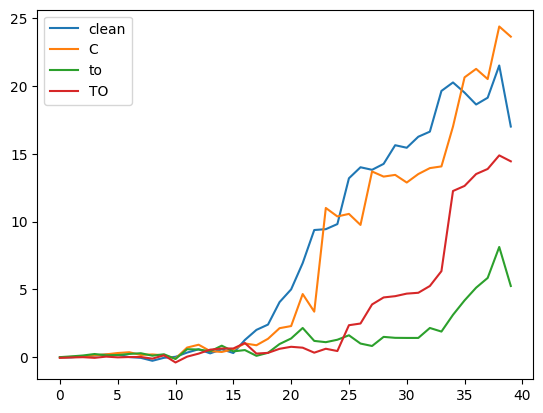

In [53]:
import matplotlib.pyplot as plt

# Create a dataframe from the token_scores dictionary
for token, scores in token_scores.items():
    plt.plot(scores, label=token)

# Show the plot
plt.legend()
plt.show()


In [42]:
hooked_model.to_str_tokens(torch.tensor([304]))

['to']

In [40]:
hooked_model.to_str_tokens(torch.tensor([7495]))

['TO']

In [43]:
hooked_model.to_str_tokens(torch.tensor([315]))

['C']

In [44]:
hooked_model.to_str_tokens(torch.tensor([5941]))

['clean']

In [28]:
topk_values, topk_indices = torch.topk(logits, k=10)


In [39]:
topk_indices

tensor([ 5941,  7897,   315, 29907, 14941, 27372, 21386,  9109,  4531,  1577],
       device='cuda:0')

In [29]:
hooked_model.to_str_tokens(topk_indices)

['clean', '?)', 'C', 'C', 'clean', 'cleaner', 'Cle', 'safe', 'cle', '?']

In [24]:
topk_indices

tensor([ 9561,  1577,  7652,  7897,  2845,  1144,  5700, 28772,  4770,  8773],
       device='cuda:0')

In [6]:
clean_lenient_prompt

'\nYou are very lenient on toxicity\n\nYou must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. \n\nHere is the text:\nYour perspective is refreshing and highly appreciated.\n\nYour response:\n('